In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [22]:
df = pd.read_csv('SolarPrediction.csv')
df

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00


In [23]:
#get max value of Radiation
max_radiation = df['Radiation'].max()
print(max_radiation)
#get min value of Radiation
min_radiation = df['Radiation'].min()
print(min_radiation)


1601.26
1.11


In [24]:


# Rename 'Data' column to 'DateTime' for clarity
df = df.rename(columns={'Data': 'DateTime'})

# Convert DateTime to pandas datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Convert Time column to datetime.time objects for better handling
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# Similarly, convert sunrise and sunset times
df['TimeSunRise'] = pd.to_datetime(df['TimeSunRise'], format='%H:%M:%S').dt.time
df['TimeSunSet'] = pd.to_datetime(df['TimeSunSet'], format='%H:%M:%S').dt.time

# Sort by DateTime to ensure proper plotting
df = df.sort_values('DateTime')
df

,UNIXTime,DateTime,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
7223,1472793006,2016-09-01,19:10:06,2.53,55,30.45,65,155.71,3.37,06:07:00,18:38:00
7257,1472781308,2016-09-01,15:55:08,628.80,63,30.42,58,1.55,6.75,06:07:00,18:38:00
7256,1472781606,2016-09-01,16:00:06,596.57,62,30.42,56,81.70,5.62,06:07:00,18:38:00
7255,1472781907,2016-09-01,16:05:07,577.10,62,30.42,57,53.61,7.87,06:07:00,18:38:00
7254,1472782211,2016-09-01,16:10:11,573.13,62,30.42,58,14.04,3.37,06:07:00,18:38:00
...,...,...,...,...,...,...,...,...,...,...,...
24714,1483206901,2016-12-31,07:55:01,39.30,43,30.31,86,262.51,5.62,06:57:00,17:54:00
24715,1483206602,2016-12-31,07:50:02,39.51,42,30.31,85,265.53,7.87,06:57:00,17:54:00
24716,1483206302,2016-12-31,07:45:02,52.87,42,30.31,84,240.48,4.50,06:57:00,17:54:00
24664,1483221902,2016-12-31,12:05:02,378.41,53,30.33,68,321.95,10.12,06:57:00,17:54:00


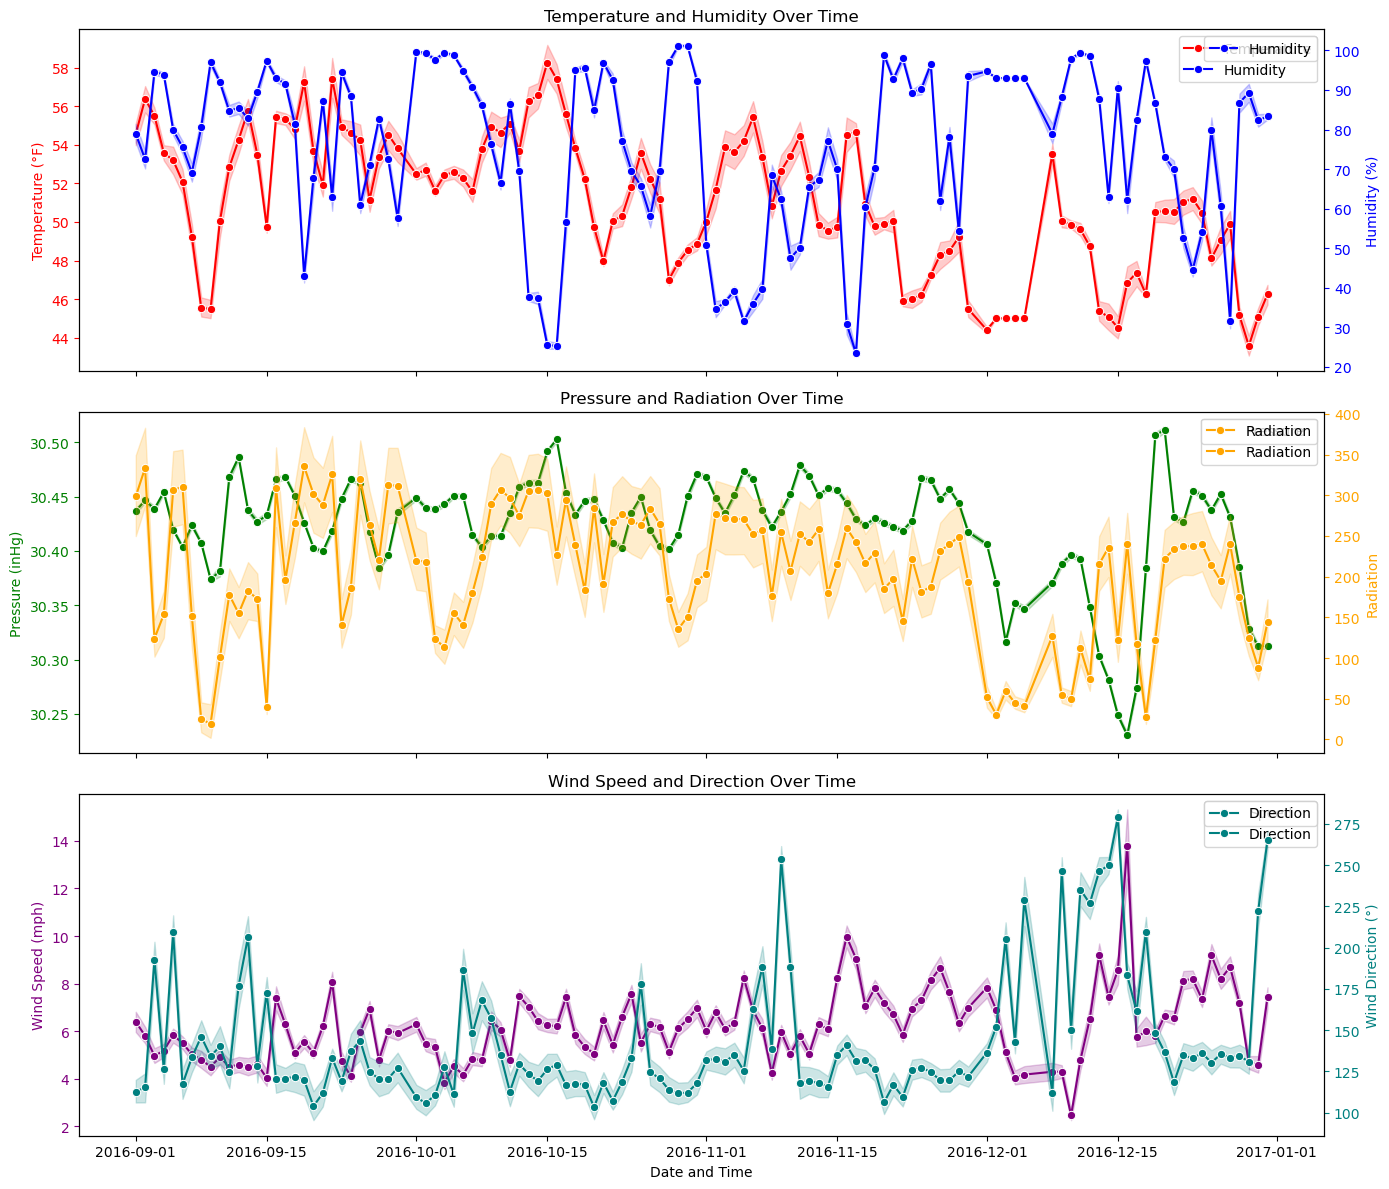

In [25]:

# Alternative visualization: Create a combined plot for related measurements
# Create a figure for related measurements (grouped by type)
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Temperature and Humidity - often related
ax1 = axes[0]
ax1.set_title('Temperature and Humidity Over Time')
ax1_twin = ax1.twinx()  # Create a twin axis for Humidity

# Plot Temperature on left axis
sns.lineplot(x='DateTime', y='Temperature', data=df, marker='o', color='red', label='Temperature', ax=ax1)
ax1.set_ylabel('Temperature (°F)', color='red')
ax1.tick_params(axis='y', colors='red')

# Plot Humidity on right axis
sns.lineplot(x='DateTime', y='Humidity', data=df, marker='o', color='blue', label='Humidity', ax=ax1_twin)
ax1_twin.set_ylabel('Humidity (%)', color='blue')
ax1_twin.tick_params(axis='y', colors='blue')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Pressure and Radiation
ax2 = axes[1]
ax2.set_title('Pressure and Radiation Over Time')
ax2_twin = ax2.twinx()  # Create a twin axis for Radiation

# Plot Pressure on left axis
sns.lineplot(x='DateTime', y='Pressure', data=df, marker='o', color='green', label='Pressure', ax=ax2)
ax2.set_ylabel('Pressure (inHg)', color='green')
ax2.tick_params(axis='y', colors='green')

# Plot Radiation on right axis
sns.lineplot(x='DateTime', y='Radiation', data=df, marker='o', color='orange', label='Radiation', ax=ax2_twin)
ax2_twin.set_ylabel('Radiation', color='orange')
ax2_twin.tick_params(axis='y', colors='orange')

# Add legend
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Wind Speed and Direction
ax3 = axes[2]
ax3.set_title('Wind Speed and Direction Over Time')
ax3_twin = ax3.twinx()  # Create a twin axis for Direction

# Plot Speed on left axis
sns.lineplot(x='DateTime', y='Speed', data=df, marker='o', color='purple', label='Speed', ax=ax3)
ax3.set_ylabel('Wind Speed (mph)', color='purple')
ax3.tick_params(axis='y', colors='purple')

# Plot Direction on right axis
sns.lineplot(x='DateTime', y='WindDirection(Degrees)', data=df, marker='o', color='teal', 
             label='Direction', ax=ax3_twin)
ax3_twin.set_ylabel('Wind Direction (°)', color='teal')
ax3_twin.tick_params(axis='y', colors='teal')

# Add legend
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Format the x-axis with appropriate date formatting for all subplots
plt.xticks(rotation=45)
ax3.set_xlabel('Date and Time')
plt.tight_layout()

plt.show()




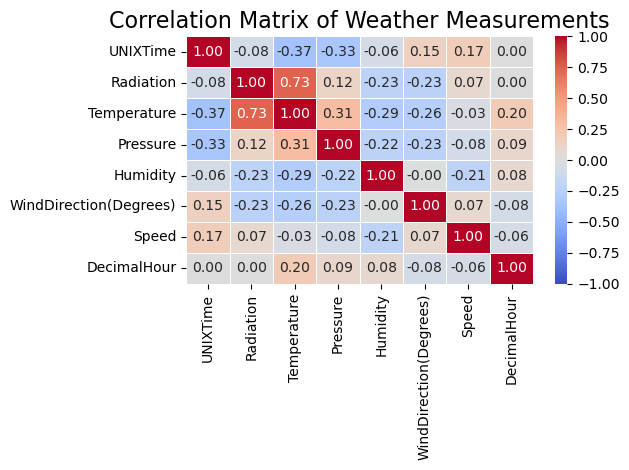

In [26]:
#plot correletions

df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour
df['Minute'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.minute
# Create a decimal hour (hour + minute/60) for better correlation
df['DecimalHour'] = df['Hour'] + df['Minute']/60

# Select only numeric columns for correlation analysis
numeric_columns = ['UNIXTime', 'Radiation', 'Temperature', 'Pressure', 
                   'Humidity', 'WindDirection(Degrees)', 'Speed', 
                   'DecimalHour']
corr_df = df[numeric_columns]

# Calculate the correlation matrix
correlation_matrix = corr_df.corr()

# 1. Create a correlation heatmap
plt.figure()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix of Weather Measurements', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## LSTM NN

In [27]:
import lstm
import data_prep

target_col = 'Radiation'  # Column to predict


X_train, X_val, X_test, y_train, y_val, y_test, scalers, feature_cols, transform_info = data_prep.prepare_weather_data(
        df,     
        target_col='Radiation',  
        window_size=24,
        feature_selection_mode='basic',  # Start with basic features
        standardize_features=False,  # Try StandardScaler
        use_solar_elevation=True,  # Try the solar elevation feature
        use_piecewise_transform=False,  # Start without piecewise transform
        log_transform=True, #figured out this one is super important
        #min_target_threshold=1.2
)


Adding solar elevation proxy feature
SolarElevation created for 32686 rows, 100.0% of data
Added 'Radiation_is_low' feature (threshold: 1.2000)
Added SolarElevation to features
Log-transformed Radiation -> Radiation_log
Using MinMaxScaler for feature scaling
X_train shape: (19596, 24, 17)
y_train shape: (19596, 1)
X_val shape: (6533, 24, 17)
y_val shape: (6533, 1)
X_test shape: (6533, 24, 17)
y_test shape: (6533, 1)
Features used: ['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeMinutesSin', 'TimeMinutesCos', 'Radiation_is_low', 'SolarElevation', 'SunriseMinutes', 'SunsetMinutes', 'DaylightMinutes', 'TimeSinceSunrise', 'TimeUntilSunset', 'DaylightPosition', 'HourOfDay']


In [28]:
import optuna
import torch
import itertools
from sklearn.metrics import r2_score
device = torch.device('cpu')
def objective(trial):
    # Define hyperparameter space
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.3, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
    clip_grad_norm = trial.suggest_categorical('clip_grad_norm', [1.0, 1.5])
    value_multiplier = trial.suggest_categorical('value_multiplier', [0.1, 0.15, 0.2])
    
    # Create model with trial parameters
    model = lstm.WeatherLSTM(
        input_dim=len(feature_cols),
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        output_dim=1,
        dropout_prob=dropout_prob
    )
    
    # Train model
    model.fit(
        X_train, y_train, X_val, y_val,
        epochs=5,  # Just 5 epochs for initial screening
        batch_size=32,
        learning_rate=learning_rate,  # Use the suggested learning rate
        scheduler_type="plateau",
        loss_type="value_aware",
        mse_weight=0.7,
        mape_weight=0.3,
        value_multiplier=value_multiplier,  # Use the suggested value multiplier
        clip_grad_norm=clip_grad_norm  # Use the suggested clip gradient norm
    )
    
    # Evaluate model
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X_val, dtype=torch.float32).to(device))
        predictions = predictions.cpu().numpy()
    
    # Calculate metrics
    r2 = r2_score(y_val, predictions)
    print(f"Trial {trial.number}: hidden_dim={hidden_dim}, num_layers={num_layers}, "
          f"dropout_prob={dropout_prob}, learning_rate={learning_rate:.6f}, "
          f"clip_grad_norm={clip_grad_norm}, value_multiplier={value_multiplier}, R²={r2:.4f}")
    
    return r2  # Return metric to maximize



# Create study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Get best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")
print(f"Best value (R²): {study.best_value:.4f}")

[I 2025-04-15 17:08:17,554] A new study created in memory with name: no-name-5237c613-f1be-43f4-8799-9e566581c0a1


X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.15)
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.138662 - Val loss: 0.062951 - Val RMSE: 0.080158 - Val R²: 0.953437 - Val MAPE: 2.60%
Epoch 2/5 - Train loss: 0.079027 - Val loss: 0.059469 - Val RMSE: 0.070550 - Val R²: 0.963931 - Val MAPE: 2.43%
Epoch 3/5 - Train loss: 0.073686 - Val loss: 0.064017 - Val RMSE: 0.067855 - Val R²: 0.966634 - Val MAPE: 2.28%
Epoch 4/5 - Train loss: 0.069478 - Val loss: 0.062096 - Val RMSE: 0.066504 - Val R²: 0.967949 - Val MAPE: 2.01%
Epoch 5/5 - Train loss: 0.065621 - Val loss: 0.056765 - Val RMSE: 0.061270 - Val R²: 0.972795 - Val MAPE: 1.95%
Training complete. Best model saved.


[I 2025-04-15 17:10:13,130] Trial 0 finished with value: 0.9727949773157395 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.00040801170068366946, 'clip_grad_norm': 1.5, 'value_multiplier': 0.15}. Best is trial 0 with value: 0.9727949773157395.


Trial 0: hidden_dim=256, num_layers=2, dropout_prob=0.2, learning_rate=0.000408, clip_grad_norm=1.5, value_multiplier=0.15, R²=0.9728
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.2)
Regularization settings:
- Dropout probability: 0.3
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.0
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.186783 - Val loss: 0.064631 - Val RMSE: 0.086367 - Val R²: 0.945943 - Val MAPE: 2.74%
Epoch 2/5 - Train loss: 0.088011 - Val loss: 0.071531 - Val RMSE: 0.085734 - Val R²: 0.946733 - Val MAPE: 3.16%
Epoch 3/5 - Train loss: 0.084313 - Val loss: 0.061916 - Val RMSE: 0.064773 - Val R²: 0.969595 - Val MAPE: 2.10%
Epoch 4/5 - Train loss: 0.080122 - Val loss: 0.065969 - Val RMSE: 0.071116 - Val R²: 0.963349 - Val MAPE: 2.26%
Epoch 5/5 - Train loss: 0.079506 - Val loss: 0.077967 - Val

[I 2025-04-15 17:13:06,322] Trial 1 finished with value: 0.956637477614536 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout_prob': 0.3, 'learning_rate': 0.0007779723880342767, 'clip_grad_norm': 1.0, 'value_multiplier': 0.2}. Best is trial 0 with value: 0.9727949773157395.


Trial 1: hidden_dim=256, num_layers=3, dropout_prob=0.3, learning_rate=0.000778, clip_grad_norm=1.0, value_multiplier=0.2, R²=0.9566
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.2)
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.250065 - Val loss: 0.093070 - Val RMSE: 0.097411 - Val R²: 0.931236 - Val MAPE: 3.15%
Epoch 2/5 - Train loss: 0.103676 - Val loss: 0.080442 - Val RMSE: 0.092768 - Val R²: 0.937634 - Val MAPE: 3.14%
Epoch 3/5 - Train loss: 0.094736 - Val loss: 0.080672 - Val RMSE: 0.082947 - Val R²: 0.950140 - Val MAPE: 2.72%
Epoch 4/5 - Train loss: 0.090303 - Val loss: 0.084236 - Val RMSE: 0.091845 - Val R²: 0.938870 - Val MAPE: 2.86%
Epoch 5/5 - Train loss: 0.087479 - Val loss: 0.076294 - Val 

[I 2025-04-15 17:14:23,301] Trial 2 finished with value: 0.9575166618713635 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout_prob': 0.2, 'learning_rate': 0.00013906595389013386, 'clip_grad_norm': 1.5, 'value_multiplier': 0.2}. Best is trial 0 with value: 0.9727949773157395.


Trial 2: hidden_dim=128, num_layers=3, dropout_prob=0.2, learning_rate=0.000139, clip_grad_norm=1.5, value_multiplier=0.2, R²=0.9575
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.1)
Regularization settings:
- Dropout probability: 0.1
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.0
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.144330 - Val loss: 0.082631 - Val RMSE: 0.119520 - Val R²: 0.896479 - Val MAPE: 4.41%
Epoch 2/5 - Train loss: 0.075287 - Val loss: 0.063478 - Val RMSE: 0.080016 - Val R²: 0.953602 - Val MAPE: 2.53%
Epoch 3/5 - Train loss: 0.069575 - Val loss: 0.065942 - Val RMSE: 0.066872 - Val R²: 0.967593 - Val MAPE: 2.19%
Epoch 4/5 - Train loss: 0.066515 - Val loss: 0.059031 - Val RMSE: 0.068743 - Val R²: 0.965754 - Val MAPE: 2.41%
Epoch 5/5 - Train loss: 0.061259 - Val loss: 0.063499 - Val 

[I 2025-04-15 17:15:25,466] Trial 3 finished with value: 0.9574214461139046 and parameters: {'hidden_dim': 256, 'num_layers': 1, 'dropout_prob': 0.1, 'learning_rate': 0.0005160826590018566, 'clip_grad_norm': 1.0, 'value_multiplier': 0.1}. Best is trial 0 with value: 0.9727949773157395.


Trial 3: hidden_dim=256, num_layers=1, dropout_prob=0.1, learning_rate=0.000516, clip_grad_norm=1.0, value_multiplier=0.1, R²=0.9574
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.2)
Regularization settings:
- Dropout probability: 0.1
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.477505 - Val loss: 0.097225 - Val RMSE: 0.113305 - Val R²: 0.906964 - Val MAPE: 3.68%
Epoch 2/5 - Train loss: 0.099302 - Val loss: 0.069608 - Val RMSE: 0.076698 - Val R²: 0.957370 - Val MAPE: 2.32%
Epoch 3/5 - Train loss: 0.087111 - Val loss: 0.060094 - Val RMSE: 0.075209 - Val R²: 0.959009 - Val MAPE: 2.43%
Epoch 4/5 - Train loss: 0.083964 - Val loss: 0.059756 - Val RMSE: 0.069460 - Val R²: 0.965036 - Val MAPE: 2.17%


[I 2025-04-15 17:15:39,625] Trial 4 finished with value: 0.9680271865899094 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout_prob': 0.1, 'learning_rate': 0.0003875352309930317, 'clip_grad_norm': 1.5, 'value_multiplier': 0.2}. Best is trial 0 with value: 0.9727949773157395.


Epoch 5/5 - Train loss: 0.081540 - Val loss: 0.057917 - Val RMSE: 0.066423 - Val R²: 0.968027 - Val MAPE: 2.01%
Training complete. Best model saved.
Trial 4: hidden_dim=64, num_layers=1, dropout_prob=0.1, learning_rate=0.000388, clip_grad_norm=1.5, value_multiplier=0.2, R²=0.9680
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.1)
Regularization settings:
- Dropout probability: 0.3
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.0
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.511291 - Val loss: 0.091995 - Val RMSE: 0.137737 - Val R²: 0.862518 - Val MAPE: 4.66%
Epoch 2/5 - Train loss: 0.171417 - Val loss: 0.078442 - Val RMSE: 0.107668 - Val R²: 0.915992 - Val MAPE: 3.41%
Epoch 3/5 - Train loss: 0.121948 - Val loss: 0.075322 - Val RMSE: 0.096800 - Val R²: 0.932096 - Val MAPE: 3.07%
Epoch 4/5 - Train loss: 

[I 2025-04-15 17:16:57,639] Trial 5 finished with value: 0.935400870572101 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout_prob': 0.3, 'learning_rate': 0.00012521587980560776, 'clip_grad_norm': 1.0, 'value_multiplier': 0.1}. Best is trial 0 with value: 0.9727949773157395.


Trial 5: hidden_dim=128, num_layers=3, dropout_prob=0.3, learning_rate=0.000125, clip_grad_norm=1.0, value_multiplier=0.1, R²=0.9354
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.1)
Regularization settings:
- Dropout probability: 0.1
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.148974 - Val loss: 0.082199 - Val RMSE: 0.101761 - Val R²: 0.924957 - Val MAPE: 3.42%
Epoch 2/5 - Train loss: 0.079008 - Val loss: 0.074611 - Val RMSE: 0.078292 - Val R²: 0.955579 - Val MAPE: 2.43%
Epoch 3/5 - Train loss: 0.072716 - Val loss: 0.064848 - Val RMSE: 0.065096 - Val R²: 0.969291 - Val MAPE: 2.13%
Epoch 4/5 - Train loss: 0.071480 - Val loss: 0.056993 - Val RMSE: 0.064529 - Val R²: 0.969824 - Val MAPE: 2.22%
Epoch 5/5 - Train loss: 0.070110 - Val loss: 0.058721 - Val 

[I 2025-04-15 17:18:17,096] Trial 6 finished with value: 0.959654200872836 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout_prob': 0.1, 'learning_rate': 0.0005569486021432085, 'clip_grad_norm': 1.5, 'value_multiplier': 0.1}. Best is trial 0 with value: 0.9727949773157395.


Trial 6: hidden_dim=128, num_layers=3, dropout_prob=0.1, learning_rate=0.000557, clip_grad_norm=1.5, value_multiplier=0.1, R²=0.9597
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.2)
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.0
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.168758 - Val loss: 0.077304 - Val RMSE: 0.082194 - Val R²: 0.951041 - Val MAPE: 2.45%
Epoch 2/5 - Train loss: 0.087296 - Val loss: 0.066199 - Val RMSE: 0.068647 - Val R²: 0.965850 - Val MAPE: 2.34%
Epoch 3/5 - Train loss: 0.082696 - Val loss: 0.075573 - Val RMSE: 0.068204 - Val R²: 0.966289 - Val MAPE: 2.24%
Epoch 4/5 - Train loss: 0.083004 - Val loss: 0.060971 - Val RMSE: 0.060876 - Val R²: 0.973144 - Val MAPE: 1.94%
Epoch 5/5 - Train loss: 0.080572 - Val loss: 0.063301 - Val 

[I 2025-04-15 17:19:08,616] Trial 7 finished with value: 0.9718509442620483 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.0008851368282874933, 'clip_grad_norm': 1.0, 'value_multiplier': 0.2}. Best is trial 0 with value: 0.9727949773157395.


Trial 7: hidden_dim=128, num_layers=2, dropout_prob=0.2, learning_rate=0.000885, clip_grad_norm=1.0, value_multiplier=0.2, R²=0.9719
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.2)
Regularization settings:
- Dropout probability: 0.1
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.0
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.325580 - Val loss: 0.142989 - Val RMSE: 0.078850 - Val R²: 0.954943 - Val MAPE: 2.72%
Epoch 2/5 - Train loss: 0.154125 - Val loss: 0.082530 - Val RMSE: 0.077805 - Val R²: 0.956130 - Val MAPE: 2.54%
Epoch 3/5 - Train loss: 0.117862 - Val loss: 0.087912 - Val RMSE: 0.079860 - Val R²: 0.953783 - Val MAPE: 2.48%
Epoch 4/5 - Train loss: 0.095101 - Val loss: 0.069568 - Val RMSE: 0.071982 - Val R²: 0.962451 - Val MAPE: 2.32%


[I 2025-04-15 17:19:22,632] Trial 8 finished with value: 0.9560379522182199 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout_prob': 0.1, 'learning_rate': 0.000249868495258192, 'clip_grad_norm': 1.0, 'value_multiplier': 0.2}. Best is trial 0 with value: 0.9727949773157395.


Epoch 5/5 - Train loss: 0.085017 - Val loss: 0.072972 - Val RMSE: 0.077887 - Val R²: 0.956038 - Val MAPE: 2.43%
Training complete. Best model saved.
Trial 8: hidden_dim=64, num_layers=1, dropout_prob=0.1, learning_rate=0.000250, clip_grad_norm=1.0, value_multiplier=0.2, R²=0.9560
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.1)
Regularization settings:
- Dropout probability: 0.1
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.276149 - Val loss: 0.069766 - Val RMSE: 0.103917 - Val R²: 0.921743 - Val MAPE: 3.26%
Epoch 2/5 - Train loss: 0.091716 - Val loss: 0.061755 - Val RMSE: 0.083996 - Val R²: 0.948871 - Val MAPE: 2.52%
Epoch 3/5 - Train loss: 0.081352 - Val loss: 0.061583 - Val RMSE: 0.078474 - Val R²: 0.955372 - Val MAPE: 2.32%
Epoch 4/5 - Train loss: 

[I 2025-04-15 17:19:48,974] Trial 9 finished with value: 0.966180905713131 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout_prob': 0.1, 'learning_rate': 0.00025243868616589614, 'clip_grad_norm': 1.5, 'value_multiplier': 0.1}. Best is trial 0 with value: 0.9727949773157395.


Epoch 5/5 - Train loss: 0.074067 - Val loss: 0.060892 - Val RMSE: 0.068314 - Val R²: 0.966181 - Val MAPE: 2.16%
Training complete. Best model saved.
Trial 9: hidden_dim=128, num_layers=1, dropout_prob=0.1, learning_rate=0.000252, clip_grad_norm=1.5, value_multiplier=0.1, R²=0.9662
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.15)
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.215097 - Val loss: 0.085113 - Val RMSE: 0.096134 - Val R²: 0.933027 - Val MAPE: 2.99%
Epoch 2/5 - Train loss: 0.101748 - Val loss: 0.110583 - Val RMSE: 0.124782 - Val R²: 0.887163 - Val MAPE: 4.58%
Epoch 3/5 - Train loss: 0.081148 - Val loss: 0.074289 - Val RMSE: 0.086742 - Val R²: 0.945473 - Val MAPE: 3.01%
Epoch 4/5 - Train loss

[I 2025-04-15 17:21:58,232] Trial 10 finished with value: 0.9587630629723978 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.0001790292326227088, 'clip_grad_norm': 1.5, 'value_multiplier': 0.15}. Best is trial 0 with value: 0.9727949773157395.


Trial 10: hidden_dim=256, num_layers=2, dropout_prob=0.2, learning_rate=0.000179, clip_grad_norm=1.5, value_multiplier=0.15, R²=0.9588
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.15)
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.0
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.126836 - Val loss: 0.065040 - Val RMSE: 0.082067 - Val R²: 0.951193 - Val MAPE: 2.64%
Epoch 2/5 - Train loss: 0.077982 - Val loss: 0.080574 - Val RMSE: 0.089097 - Val R²: 0.942473 - Val MAPE: 3.02%
Epoch 3/5 - Train loss: 0.076480 - Val loss: 0.103196 - Val RMSE: 0.116682 - Val R²: 0.901336 - Val MAPE: 4.51%
Epoch 4/5 - Train loss: 0.074970 - Val loss: 0.065874 - Val RMSE: 0.062050 - Val R²: 0.972098 - Val MAPE: 2.18%
Epoch 5/5 - Train loss: 0.072956 - Val loss: 0.061894 - V

[I 2025-04-15 17:24:11,797] Trial 11 finished with value: 0.9745133848720324 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.0009153166419575164, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15}. Best is trial 11 with value: 0.9745133848720324.


Trial 11: hidden_dim=256, num_layers=2, dropout_prob=0.2, learning_rate=0.000915, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9745
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.15)
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.0
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.139453 - Val loss: 0.084543 - Val RMSE: 0.113281 - Val R²: 0.907005 - Val MAPE: 3.64%
Epoch 2/5 - Train loss: 0.082360 - Val loss: 0.070540 - Val RMSE: 0.068809 - Val R²: 0.965689 - Val MAPE: 2.23%
Epoch 3/5 - Train loss: 0.075205 - Val loss: 0.058036 - Val RMSE: 0.073858 - Val R²: 0.960468 - Val MAPE: 2.39%
Epoch 4/5 - Train loss: 0.075012 - Val loss: 0.080959 - Val RMSE: 0.079632 - Val R²: 0.954046 - Val MAPE: 2.62%
Epoch 5/5 - Train loss: 0.074080 - Val loss: 0.061641 - V

[I 2025-04-15 17:26:25,355] Trial 12 finished with value: 0.9675038244376319 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.0005891283841393161, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15}. Best is trial 11 with value: 0.9745133848720324.


Trial 12: hidden_dim=256, num_layers=2, dropout_prob=0.2, learning_rate=0.000589, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9675
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.15)
Regularization settings:
- Dropout probability: 0.3
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.162212 - Val loss: 0.074168 - Val RMSE: 0.099373 - Val R²: 0.928438 - Val MAPE: 3.16%
Epoch 2/5 - Train loss: 0.087836 - Val loss: 0.066204 - Val RMSE: 0.072399 - Val R²: 0.962015 - Val MAPE: 2.38%
Epoch 3/5 - Train loss: 0.080965 - Val loss: 0.060073 - Val RMSE: 0.068229 - Val R²: 0.966265 - Val MAPE: 2.15%
Epoch 4/5 - Train loss: 0.078919 - Val loss: 0.056716 - Val RMSE: 0.065129 - Val R²: 0.969260 - Val MAPE: 2.02%
Epoch 5/5 - Train loss: 0.077252 - Val loss: 0.065411 - V

[I 2025-04-15 17:28:37,814] Trial 13 finished with value: 0.9451571398123778 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout_prob': 0.3, 'learning_rate': 0.00037100997830471306, 'clip_grad_norm': 1.5, 'value_multiplier': 0.15}. Best is trial 11 with value: 0.9745133848720324.


Trial 13: hidden_dim=256, num_layers=2, dropout_prob=0.3, learning_rate=0.000371, clip_grad_norm=1.5, value_multiplier=0.15, R²=0.9452
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.15)
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.0
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.162641 - Val loss: 0.107079 - Val RMSE: 0.113102 - Val R²: 0.907298 - Val MAPE: 4.20%
Epoch 2/5 - Train loss: 0.083906 - Val loss: 0.058301 - Val RMSE: 0.066693 - Val R²: 0.967766 - Val MAPE: 2.07%
Epoch 3/5 - Train loss: 0.077852 - Val loss: 0.064267 - Val RMSE: 0.065860 - Val R²: 0.968566 - Val MAPE: 2.23%
Epoch 4/5 - Train loss: 0.076208 - Val loss: 0.069660 - Val RMSE: 0.069849 - Val R²: 0.964643 - Val MAPE: 2.15%
Epoch 5/5 - Train loss: 0.074234 - Val loss: 0.064560 - V

[I 2025-04-15 17:30:34,737] Trial 14 finished with value: 0.9729188814386822 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.0009996159482112753, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15}. Best is trial 11 with value: 0.9745133848720324.


Trial 14: hidden_dim=256, num_layers=2, dropout_prob=0.2, learning_rate=0.001000, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9729
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.15)
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.0
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.125369 - Val loss: 0.079988 - Val RMSE: 0.102970 - Val R²: 0.923163 - Val MAPE: 3.45%
Epoch 2/5 - Train loss: 0.077622 - Val loss: 0.062730 - Val RMSE: 0.080400 - Val R²: 0.953155 - Val MAPE: 2.99%
Epoch 3/5 - Train loss: 0.075819 - Val loss: 0.064787 - Val RMSE: 0.073709 - Val R²: 0.960628 - Val MAPE: 2.25%
Epoch 4/5 - Train loss: 0.074750 - Val loss: 0.056337 - Val RMSE: 0.057664 - Val R²: 0.975903 - Val MAPE: 1.87%
Epoch 5/5 - Train loss: 0.072587 - Val loss: 0.076073 - V

[I 2025-04-15 17:32:45,837] Trial 15 finished with value: 0.9627360811740857 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.0009257166085832441, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15}. Best is trial 11 with value: 0.9745133848720324.


Trial 15: hidden_dim=256, num_layers=2, dropout_prob=0.2, learning_rate=0.000926, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9627
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.15)
Regularization settings:
- Dropout probability: 0.3
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.0
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.203237 - Val loss: 0.073988 - Val RMSE: 0.097896 - Val R²: 0.930549 - Val MAPE: 2.97%
Epoch 2/5 - Train loss: 0.106818 - Val loss: 0.078939 - Val RMSE: 0.075229 - Val R²: 0.958987 - Val MAPE: 2.32%
Epoch 3/5 - Train loss: 0.100037 - Val loss: 0.100037 - Val RMSE: 0.078722 - Val R²: 0.955091 - Val MAPE: 2.68%
Epoch 4/5 - Train loss: 0.099396 - Val loss: 0.082981 - Val RMSE: 0.072326 - Val R²: 0.962091 - Val MAPE: 2.45%
Epoch 5/5 - Train loss: 0.095936 - Val loss: 0.067783 - V

[I 2025-04-15 17:33:13,671] Trial 16 finished with value: 0.9593990423277445 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout_prob': 0.3, 'learning_rate': 0.0007067477726335781, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15}. Best is trial 11 with value: 0.9745133848720324.


Trial 16: hidden_dim=64, num_layers=2, dropout_prob=0.3, learning_rate=0.000707, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9594
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.15)
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.0
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.156989 - Val loss: 0.079290 - Val RMSE: 0.074560 - Val R²: 0.959713 - Val MAPE: 2.68%
Epoch 2/5 - Train loss: 0.079310 - Val loss: 0.074975 - Val RMSE: 0.080109 - Val R²: 0.953494 - Val MAPE: 2.62%
Epoch 3/5 - Train loss: 0.075930 - Val loss: 0.071467 - Val RMSE: 0.066493 - Val R²: 0.967959 - Val MAPE: 2.08%
Epoch 4/5 - Train loss: 0.076367 - Val loss: 0.065169 - Val RMSE: 0.070309 - Val R²: 0.964177 - Val MAPE: 2.27%
Epoch 5/5 - Train loss: 0.073951 - Val loss: 0.060926 - Va

[I 2025-04-15 17:34:18,123] Trial 17 finished with value: 0.9686332425736558 and parameters: {'hidden_dim': 256, 'num_layers': 1, 'dropout_prob': 0.2, 'learning_rate': 0.000999855320449868, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15}. Best is trial 11 with value: 0.9745133848720324.


Trial 17: hidden_dim=256, num_layers=1, dropout_prob=0.2, learning_rate=0.001000, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9686
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.15)
Regularization settings:
- Dropout probability: 0.3
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.0
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.167532 - Val loss: 0.084950 - Val RMSE: 0.106738 - Val R²: 0.917436 - Val MAPE: 3.69%
Epoch 2/5 - Train loss: 0.087426 - Val loss: 0.089081 - Val RMSE: 0.099672 - Val R²: 0.928007 - Val MAPE: 3.65%
Epoch 3/5 - Train loss: 0.081540 - Val loss: 0.074320 - Val RMSE: 0.105306 - Val R²: 0.919637 - Val MAPE: 3.90%
Epoch 4/5 - Train loss: 0.080697 - Val loss: 0.065749 - Val RMSE: 0.060361 - Val R²: 0.973596 - Val MAPE: 1.89%
Epoch 5/5 - Train loss: 0.077957 - Val loss: 0.054529 - V

[I 2025-04-15 17:37:32,811] Trial 18 finished with value: 0.9731360462018976 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout_prob': 0.3, 'learning_rate': 0.0006991545700333057, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15}. Best is trial 11 with value: 0.9745133848720324.


Trial 18: hidden_dim=256, num_layers=3, dropout_prob=0.3, learning_rate=0.000699, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9731
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.15)
Regularization settings:
- Dropout probability: 0.3
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.0
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.187133 - Val loss: 0.117434 - Val RMSE: 0.082929 - Val R²: 0.950162 - Val MAPE: 2.82%
Epoch 2/5 - Train loss: 0.088714 - Val loss: 0.097119 - Val RMSE: 0.099068 - Val R²: 0.928875 - Val MAPE: 3.60%
Epoch 3/5 - Train loss: 0.082664 - Val loss: 0.061462 - Val RMSE: 0.061722 - Val R²: 0.972393 - Val MAPE: 1.85%
Epoch 4/5 - Train loss: 0.080161 - Val loss: 0.068694 - Val RMSE: 0.059175 - Val R²: 0.974624 - Val MAPE: 1.97%
Epoch 5/5 - Train loss: 0.078464 - Val loss: 0.058983 - V

[I 2025-04-15 17:40:42,793] Trial 19 finished with value: 0.9647387773773095 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout_prob': 0.3, 'learning_rate': 0.0006629046740531455, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15}. Best is trial 11 with value: 0.9745133848720324.


Trial 19: hidden_dim=256, num_layers=3, dropout_prob=0.3, learning_rate=0.000663, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9647
Best parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.0009153166419575164, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15}
Best value (R²): 0.9745


In [31]:


input_dim = len(feature_cols)  # Number of features
hidden_dim = 256  # Number of hidden units (increased from 64)
num_layers = 2  # Number of LSTM layers
output_dim = 1  # Dimension of output (predicting a single value)
mse_weight=0.7
mape_weight=0.3
dropout_prob = 0.3
 
# Initialize model
device = torch.device('cpu')
model = lstm.WeatherLSTM(input_dim, hidden_dim, num_layers, output_dim, dropout_prob).to(device)

# Store complete transform info in the model
#model.transform_info = transform_info  # Store the whole transform_info object
    

In [32]:
# Train the model with advanced features
model.fit(
        X_train, y_train, X_val, y_val, 
        epochs=100, 
        batch_size=32, 
        learning_rate=0.000915, 
        patience=20,  # Increased patience for better convergence 
        device=device,
        scheduler_type="cosine",  # Try cosine annealing scheduler
        weight_decay=0.001,  # L2 regularization
        clip_grad_norm=1.0,  # Gradient clipping
        loss_type="value_aware",
        mse_weight=mse_weight,
        mape_weight=mape_weight,
        value_multiplier=0.15 #adjust
    )


X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.15)
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 0.001
- Gradient clipping norm: 1.0
Using CosineAnnealingLR scheduler with T_max=100
Epoch 1/100 - Train loss: 0.145570 - Val loss: 0.135538 - Val RMSE: 0.101171 - Val R²: 0.925824 - Val MAPE: 3.55%
Epoch 2/100 - Train loss: 0.085919 - Val loss: 0.075646 - Val RMSE: 0.083392 - Val R²: 0.949604 - Val MAPE: 2.71%
Epoch 3/100 - Train loss: 0.081267 - Val loss: 0.079342 - Val RMSE: 0.082316 - Val R²: 0.950896 - Val MAPE: 2.61%
Epoch 4/100 - Train loss: 0.081042 - Val loss: 0.066367 - Val RMSE: 0.073874 - Val R²: 0.960451 - Val MAPE: 2.23%
Epoch 5/100 - Train loss: 0.079044 - Val loss: 0.072323 - Val RMSE: 0.075189 - Val R²: 0.959031 - Val MAPE: 2.34%
Epoch 6/100 - Train loss: 0.078509 - Val loss: 0.081856

WeatherLSTM(
  (lstm): LSTM(17, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

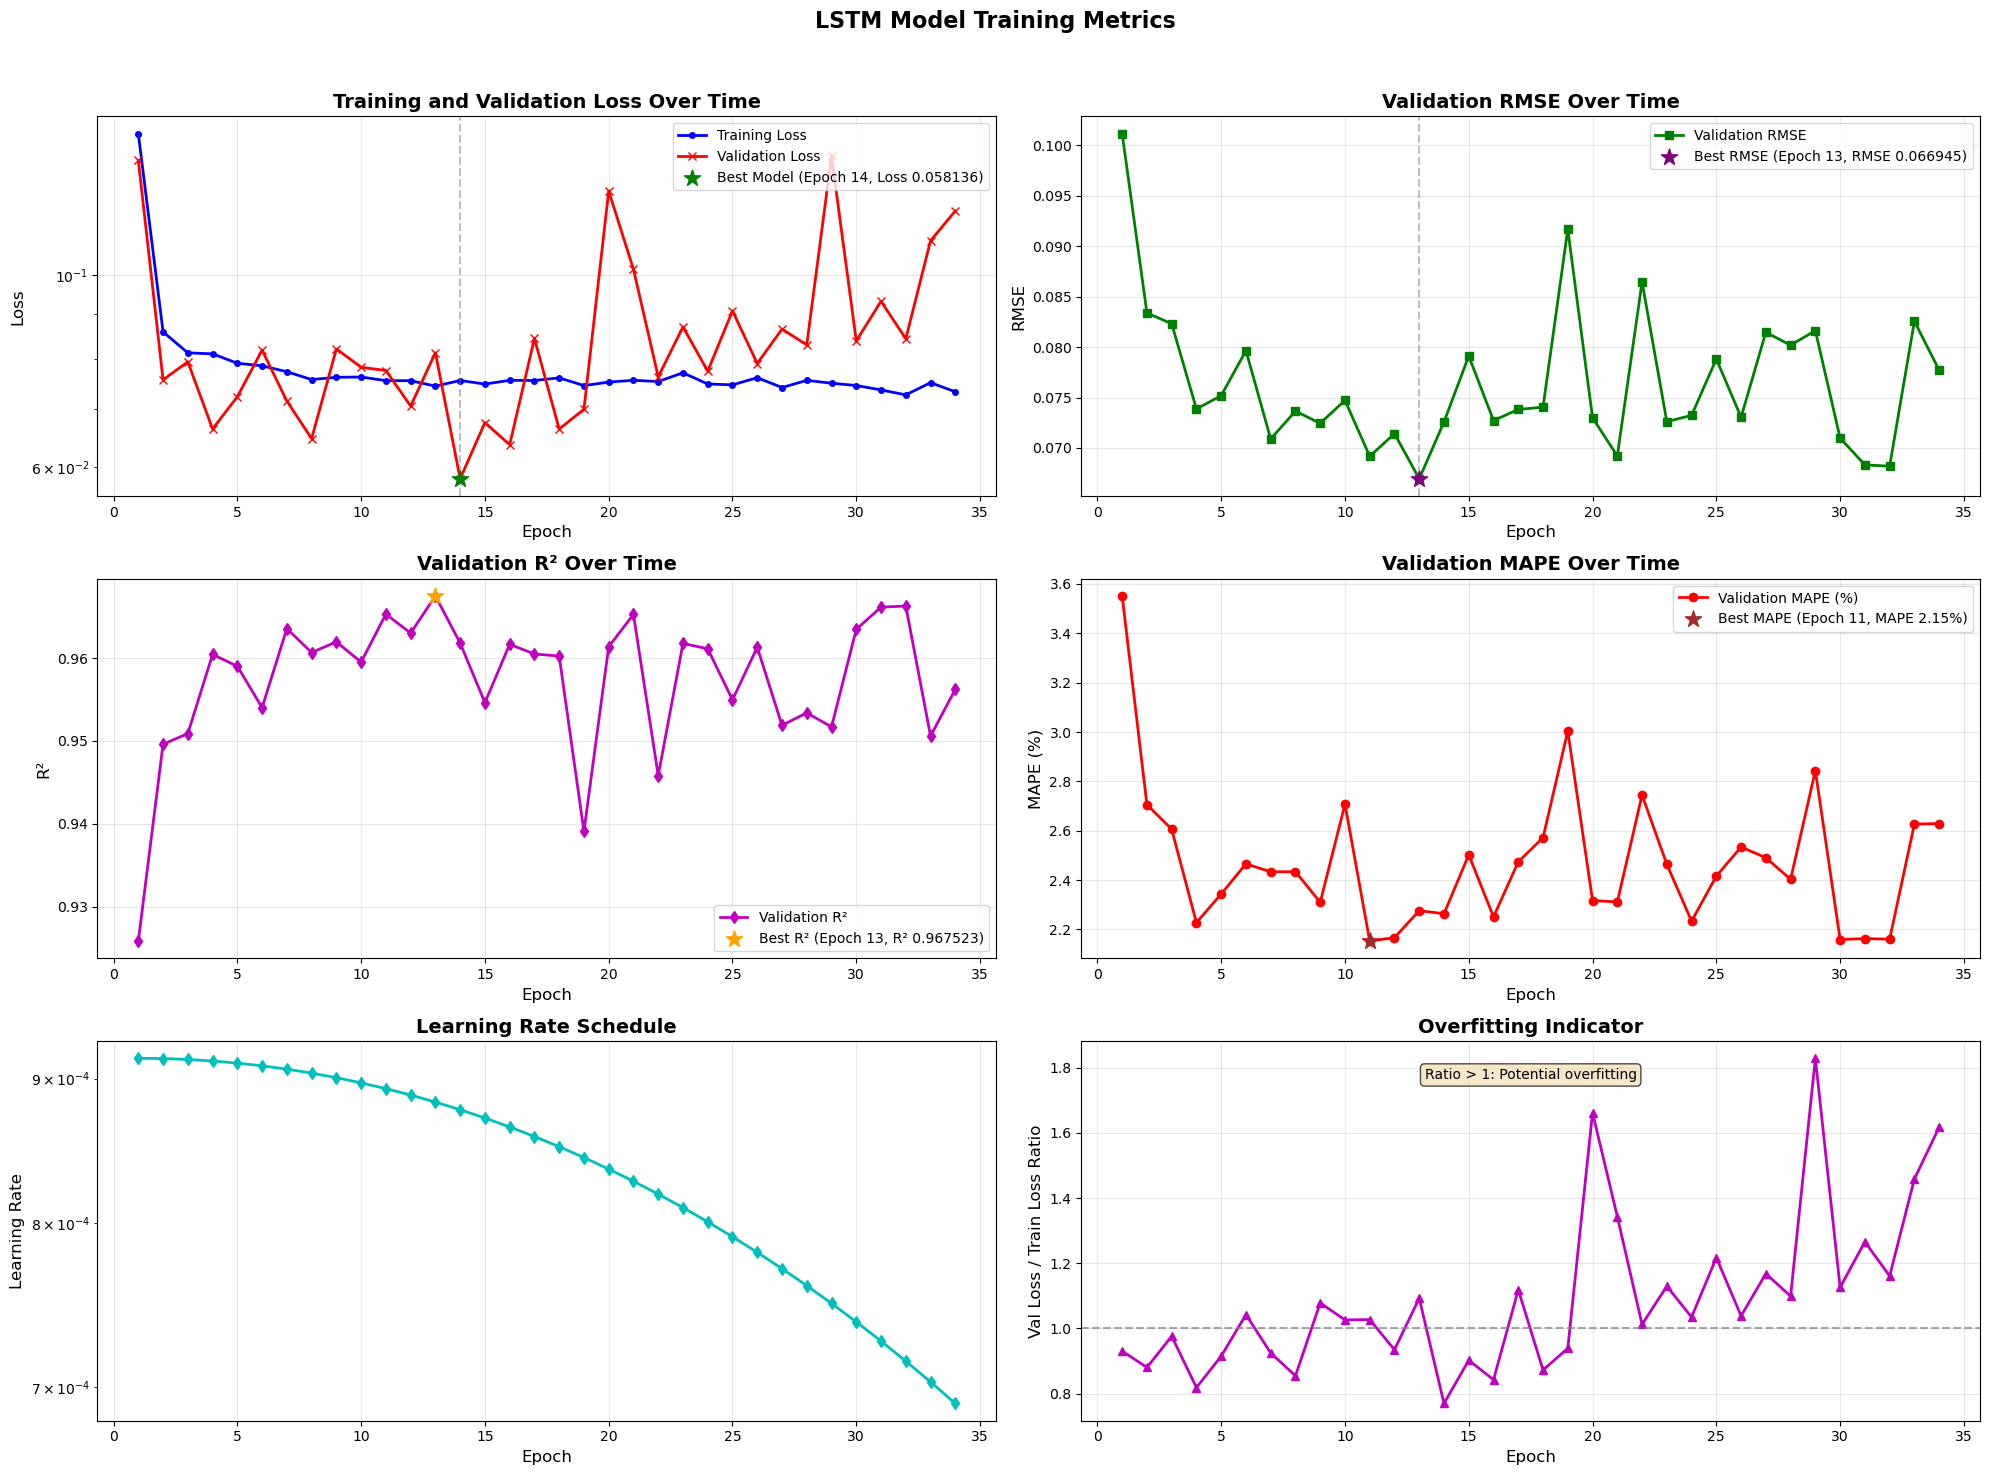

In [33]:
# Visualize training metrics
fig = model.plot_training_history()
plt.show()
model.transform_info = transform_info  # Store the whole transform_info object

In [34]:
# Evaluate on test data
predictions, actuals, metrics = model.evaluate(
        X_test, y_test,
    target_scaler=scalers["Radiation_log"],
    transform_info=transform_info,  # Pass the complete transform_info
    )
    
    
# Calculate RMSE in original scale
rmse = np.sqrt(np.mean((predictions - actuals) ** 2))
#print(f"Test RMSE (original scale): {rmse:.4f}")
    


Scaled Metrics:
Test RMSE: 0.100549
Test R²: 0.925076
Test MAPE (capped at 100%): 24.13%

Original Scale Metrics:
Test RMSE: 121.195587
Test R²: 0.791699
Test MAPE (capped at 100%): 28.62%


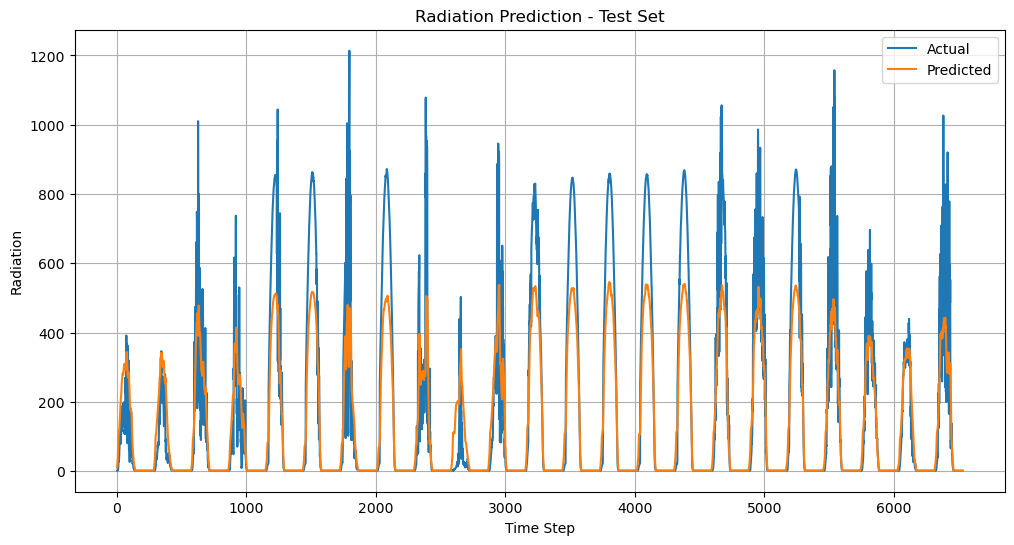

In [35]:
#plot predictions

plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Radiation Prediction - Test Set')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

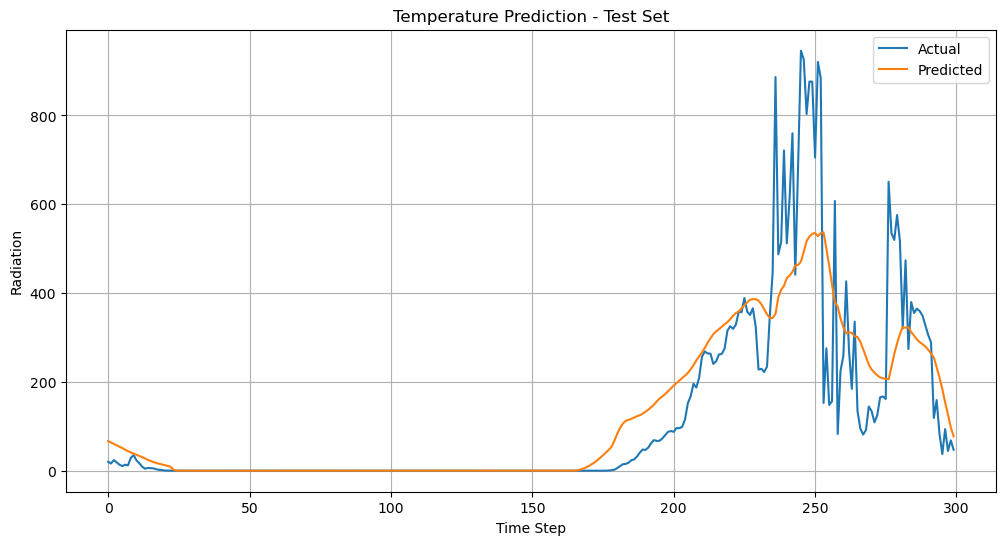

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(actuals[2700:3000], label='Actual')
plt.plot(predictions[2700:3000], label='Predicted')
plt.title('Temperature Prediction - Test Set')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

Resampling data to 1min frequency...
Original data points: 6533, After resampling: 6533
Evaluation Summary:
Number of samples (after resampling): 6533
RMSE: 121.195586
MAE: 63.336811
MAPE: 102.32%
R²: 0.791699
Correlation: 0.936354


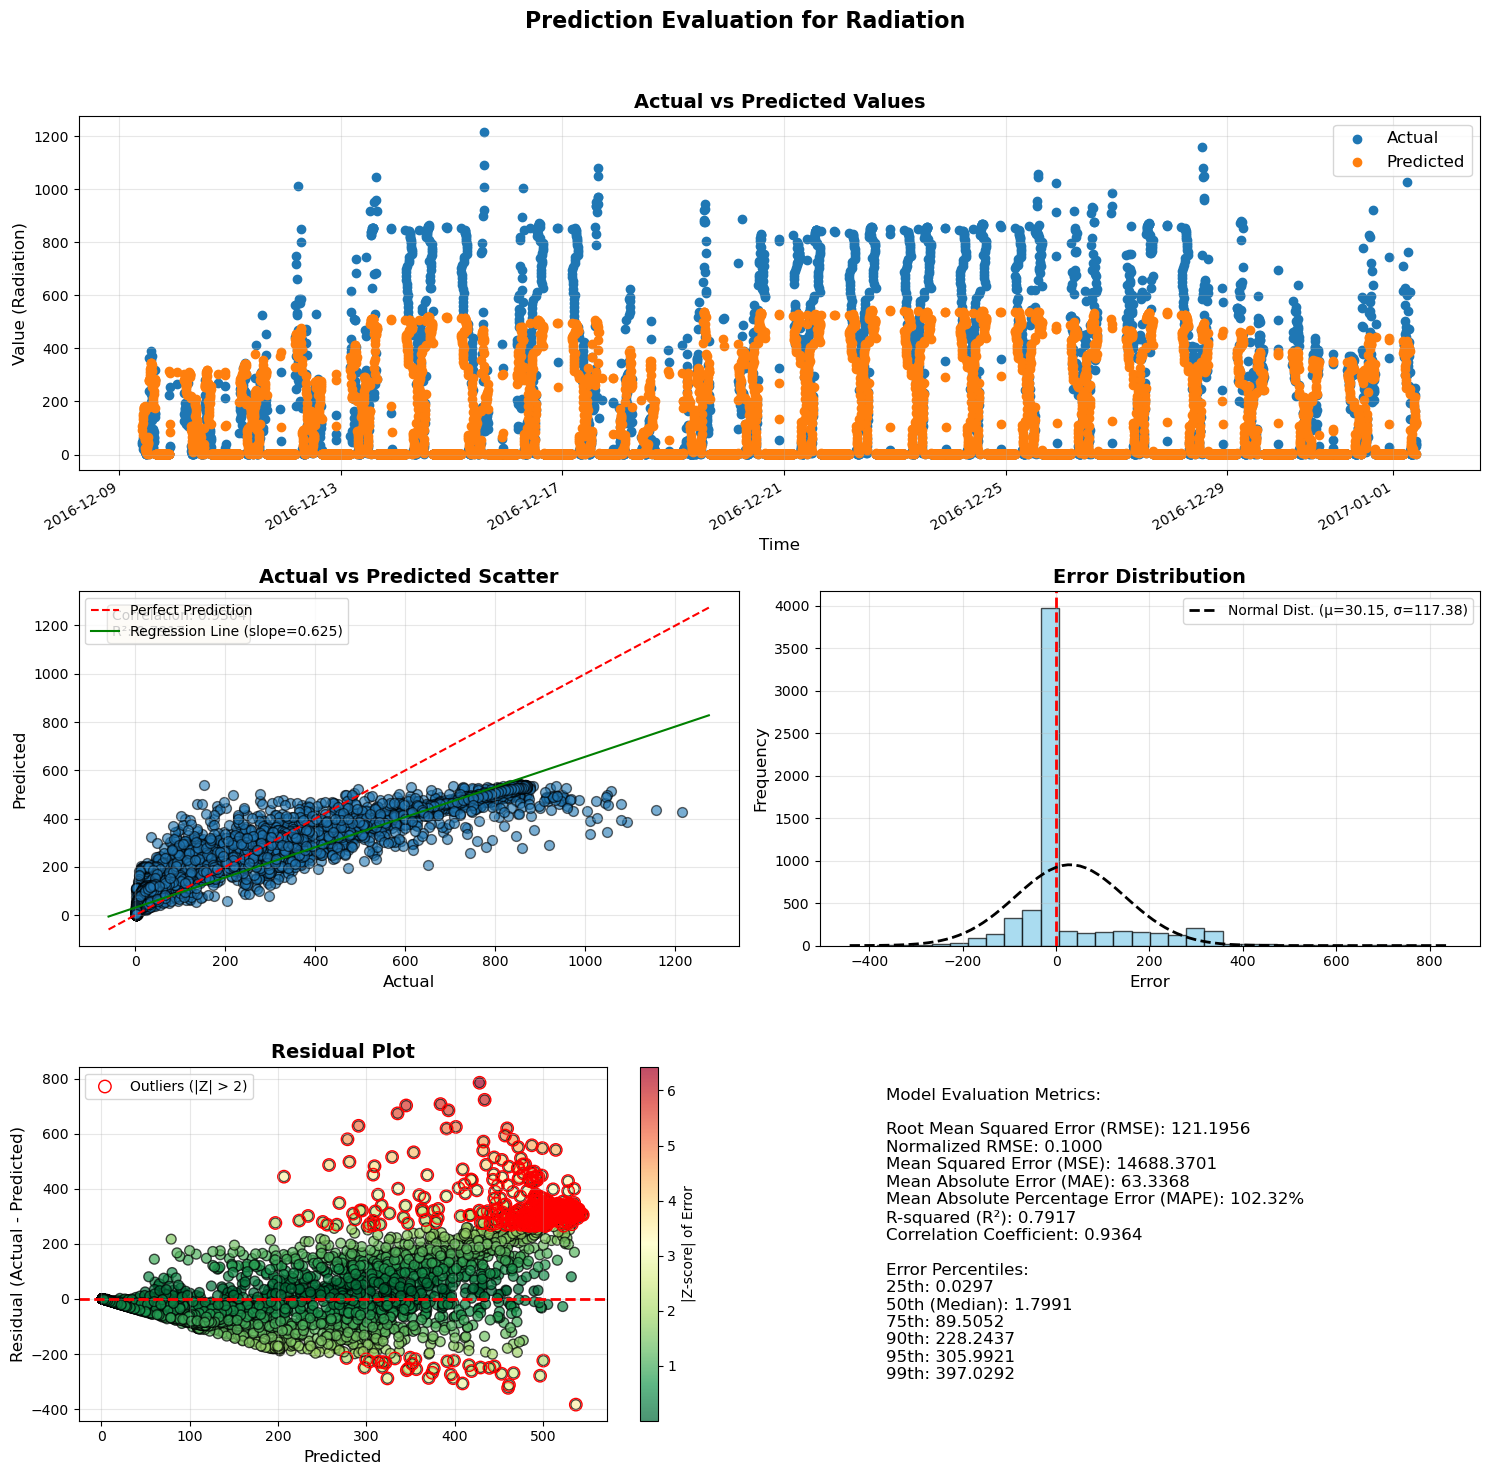

In [37]:
import plot_utils as pu 

# You can create timestamps if your data has a time component
timestamps = df['UNIXTime'].values[-len(predictions):]  # assuming UNIXTime exists in your df

# Make sure scaler is a dictionary with target_col as key
if not isinstance(scalers, dict):
    scalers_dict = {target_col: scalers}
else:
    scalers_dict = scalers

fig_eval = pu.create_evaluation_dashboard(
    predictions=predictions, 
    actuals=actuals, 
    scalers=None,  # !!! there is a bug here
    target_col=target_col,
    timestamps=timestamps
)




## Key Performance Metrics
- **RMSE: 69.7374**
- **Normalized RMSE: 0.0575** (excellent - below 0.1 indicates strong fit)
- **MAE: 33.1875**
- **MAPE: 37.98%**
- **R²: 0.9310**
- **Correlation Coefficient: 0.9656**

## Error Distribution Analysis

The error percentiles reveal a fascinating pattern:

| Percentile | Error Value |
|------------|-------------|
| 25th       | 0.0217      |
| 50th (Median) | 0.0817   |
| 75th       | 46.7872     |
| 90th       | 99.8823     |
| 95th       | 143.1077    |
| 99th       | 293.8402    |

## Insights

1. **Excellent Median Performance**: The median error of only 0.0817 indicates that at least 50% of the predictions are extremely accurate.

2. **Right-Skewed Error Distribution**: The dramatic jump between the 50th percentile (0.0817) and the 75th percentile (46.7872) reveals a highly skewed error distribution.

3. **Targeted Improvement Opportunity**: The large gap between percentiles suggests that the model is highly accurate for most cases but struggles significantly with a specific subset of observations.

4. **Performance Dichotomy**: The excellent normalized RMSE (0.0575) and R² (0.93) alongside the higher MAPE (37.98%) confirm that the model generally performs well but likely struggles with smaller radiation values where small absolute errors translate to large percentage errors.


In [38]:
model.save('weather_lstm_model.pt')

Model saved to weather_lstm_model.pt


# Weather Prediction LSTM Model: Technical Summary

## Model Architecture

**WeatherLSTM Network Structure:**<br>
┌─────────────────────────────────────────────────────┐<br>
│ ➤ LSTM Layer (16→256, layers=2, dropout=0.3)        │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (256→128)                   │<br>
│ ➤ ReLU Activation                                   │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (128→64)                    │<br>
│ ➤ ReLU Activation                                   │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (64→1)                      │<br>
└─────────────────────────────────────────────────────┘

## Core Parameters
- **Input Dimension**: 16 features
- **Hidden Dimension**: 256 (increased from 64)
- **LSTM Layers**: 2
- **Output Dimension**: 1 (predicting a single value)
- **Dropout Probability**: 0.3 (applied at multiple layers)
- **Fully Connected Layers**: 256→128→64→1 with ReLU activations

## Dataset Structure
- **Training Set**: X_train shape: (19596, 24, 16), y_train shape: (19596, 1)
- **Validation Set**: X_val shape: (6533, 24, 16), y_val shape: (6533, 1)
- **Data Format**: 24 timesteps with 16 features per timestep

## Loss Function
The model uses a combined loss function:

$\mathcal{L}_{combined} = 0.7 \times \mathcal{L}_{MSE} + 0.3 \times \mathcal{L}_{MAPE}$

Where:
- $\mathcal{L}_{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_{true} - y_{pred})^2$
- $\mathcal{L}_{MAPE} = \frac{1}{n}\sum_{i=1}^{n}\left|\frac{y_{true} - y_{pred}}{|y_{true}| + \epsilon}\right| \times 100\%$
  - With $\epsilon = 1.0$ to protect against division by zero

## Regularization Techniques
- **Dropout**: Probability of 0.3 at LSTM and after each fully connected layer
- **L2 Regularization**: Weight decay of 0.0001
- **Gradient Clipping**: Norm constrained to 1.0

## Optimization Strategy
- **Learning Rate Scheduler**: CosineAnnealingLR with T_max=100
- **Patience for Early Stopping**: 15 epochs

## Data Transformation
- **Log Transformation**: Applied to Radiation values
  - $Radiation_{log} = \log(Radiation + \epsilon)$
  - Where $\epsilon$ is a small constant (1e-06) to prevent log(0)
- **Feature Engineering**: Added 'Radiation_is_low' binary feature (threshold: 1.2)

## Input Features
16 features including:
- Raw measurements: Radiation, Temperature, Pressure, Humidity, Wind Direction, Speed
- Engineered features: Radiation_is_low, SunriseMinutes, SunsetMinutes, DaylightMinutes
- Temporal features: TimeSinceSunrise, TimeUntilSunset, DaylightPosition
- Cyclical time encoding: TimeMinutesSin, TimeMinutesCos, HourOfDay

This architecture optimally balances model complexity with regularization to prevent overfitting while capturing the temporal patterns in weather data for accurate radiation prediction.